In [158]:
using LinearAlgebra
using Distributions
using Plots
using ColorSchemes

## Parametros de error instrumentos

Δt = 0.1

fs = 10
fs2 = 1
PSD_a = 80*10*1e-6
PSD_g = 0.03*π/180
PSD_m = 100e-6*1e-4
B_T = 25358e-9

err_IMU_x = PSD_a*sqrt(fs)
err_IMU_θ = PSD_g*sqrt(fs)

err_GPS = 2.5
err_MAG = PSD_m*sqrt(fs2)/B_T

Q = [err_IMU_x^2 0 0; 0 err_IMU_x^2 0; 0 0 err_IMU_θ^2]

R = [err_GPS^2 0 0; 0 err_GPS^2 0; 0 0 err_MAG^2]

dist_ruido_IMU = MvNormal([0,0,0], Q)
dist_ruido_GPS = MvNormal([0,0,0], R)


println(Q)
println(R)

[6.4000000000000006e-6 0.0 0.0; 0.0 6.4000000000000006e-6 0.0; 0.0 0.0 2.7415567780803773e-6]
[6.25 0.0 0.0; 0.0 6.25 0.0; 0.0 0.0 1.5551418366801118e-7]


In [159]:
# Generadores de datos 

function estatico_IMU()
    return [0,0,0]
end
function estatico_GPS()
    return [0,0,0]
end

estatico_GPS (generic function with 1 method)

In [160]:
## Matrices filtro Kalman

A = [1 Δt 0 0 0;
     0 1 0 0 0;
     0 0 1 Δt 0;
     0 0 0 1 0;
     0 0 0 0 1]

function B_matrix(θ)
    return [Δt^2*cos(θ)/2 -Δt^2*sin(θ)/2 0;
    Δt*cos(θ) -Δt*sin(θ) 0;
    Δt^2*sin(θ)/2 Δt^2*cos(θ)/2 0;
    Δt*sin(θ) Δt*cos(θ) 0;
    0 0 Δt]
end

H = [1 0 0 0 0;
     0 0 1 0 0;
     0 0 0 0 1]

3×5 Matrix{Int64}:
 1  0  0  0  0
 0  0  1  0  0
 0  0  0  0  1

In [161]:
function kalman_predict(x, u, P)
    B = B_matrix(x[5])
    x_est = A*x + B*u
    P_est = A*P*A' + B*Q*B'
    K = P_est*H'*inv(H*P_est*H'+R)
    return x_est, P_est, K
end

function kalman_correct(x_prior, z, P_prior, K)
    x_est = x_prior + K*(z-H*x_prior)
    P_est = (I-K*H)*P_prior
    return x_est, P_est
end

function kalman_initialize(t, z)
    N = length(t)
    x = zeros(5, N)
    x[1:2:5,1] = z[:,1]
    P = zeros(5, 5, N)
    P[:,:,1] = diagm([err_GPS^2,(err_GPS*fs2)^2,err_GPS^2,(err_GPS*fs2)^2,2pi])
    K = zeros(5, 3, N)
    return x, P, K
end

function kalman(t, tasa_GPS, u, z)
    x, P, K = kalman_initialize(t, z)
    for k in 2:length(t)
        x_est, P_est, K_k = kalman_predict(x[:,k-1], u[:,k], P[:,:,k-1])
        if k%tasa_GPS == 0
            x_est, P_est = kalman_correct(x_est, z[:,k], P_est, K_k)
        end
        x[:,k] = x_est
        P[:,:,k] = P_est
        K[:,:,k] = K_k
    end
    return x, P, K
end

kalman (generic function with 1 method)

In [162]:
T = 500
t = 0:0.1:T

u_true = hcat([estatico_IMU() for ti in t]...)
u_noise = hcat([rand(dist_ruido_IMU) for ti in t]...)
z_true = hcat([estatico_GPS() for ti in t]...)
z_noise = hcat([rand(dist_ruido_GPS) for ti in t]...)
u = u_true + u_noise
z = z_true + z_noise
x, P, K = kalman(t, 10, u, z)

([-1.455122915634084 -1.4551266946649777 … 0.43661832450277066 0.4373575556776893; 0.0 -7.558061787461232e-5 … 0.007282315604079254 0.007502307894293981; … ; 0.0 -0.00016725030909564152 … 0.0007199402423739461 0.0009028827275953279; 0.00014334875152236039 0.00027569479676976794 … -0.0006970379408270451 -0.001048817905282591], [6.25 0.0 … 0.0 0.0; 0.0 6.25 … 0.0 0.0; … ; 0.0 0.0 … 6.25 0.0; 0.0 0.0 … 0.0 6.283185307179586;;; 6.31250000016 0.6250000032 … -6.003137944404287e-29 0.0; 0.6250000032 6.250000064 … -1.1198482454656182e-27 0.0; … ; -3.2322725620722296e-29 1.1126949727411405e-27 … 6.250000064 0.0; 0.0 0.0 … 0.0 6.283185334595154;;; 6.5000000016 1.2500000128000002 … -1.8461988969980026e-28 0.0; 1.2500000128000002 6.250000128 … 1.3745759714928516e-27 0.0; … ; -4.212872148581202e-29 -1.6912795474562842e-27 … 6.250000128 0.0; 0.0 0.0 … 0.0 6.283185362010721;;; … ;;; 0.15972719705013783 0.002020370544845382 … -9.236402287804786e-25 0.0; 0.002020370544845382 5.0854141278523966e-5 … -1.

In [163]:
println(length(t))

5001


In [164]:
function trayectoria_xy(x, z_true)
    p1 = plot(x[1,:], x[3,:], label="Estimación", xlabel="x", ylabel="y", aspect_ratio=:equal, title="Trayectoria XY")
    plot!(p1, z_true[1,:], z_true[2,:], label="Trayectoria")
    return p1
end

function trayectoria_t(t, x, z_true)
    p1 = plot(t, x[1,:], ylabel="x [m]", title="Trayectoria en función del tiempo")
    plot!(p1, t, z_true[1,:])
    p2 = plot(t, x[3,:], ylabel="y [m]")
    plot!(p2, t, z_true[2,:])
    p3 = plot(t, x[5,:] .% 2pi, ylabel="θ", xlabel="t [s]")
    plot!(p3, t, z_true[3,:] .% 2pi)
    return plot(p1,p2,p3, layout=(3,1), legend=false)
end

trayectoria_t (generic function with 1 method)

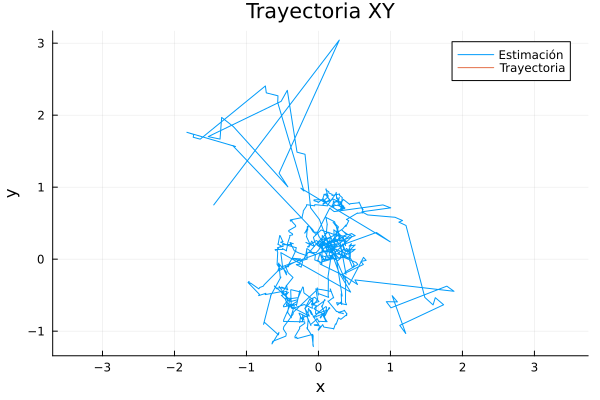

In [165]:
trayectoria_xy(x, z_true)

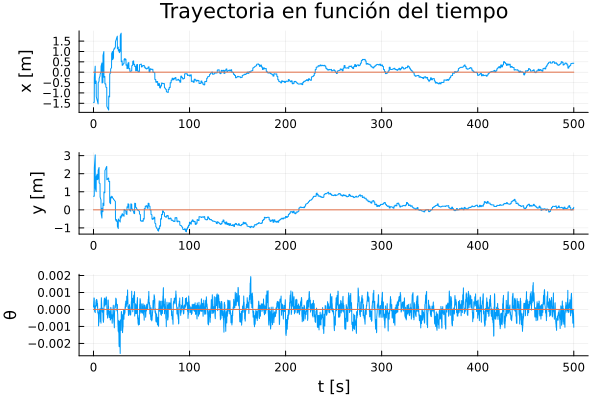

In [166]:
trayectoria_t(t, x, z_true)

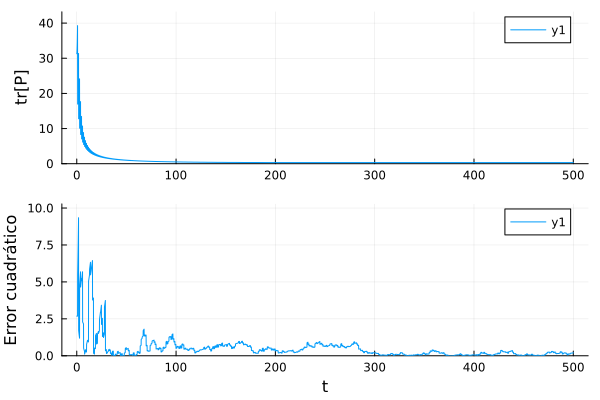

In [ ]:
function varianza_estimador(P)
    return [tr(P[:,:,i]) for i in 1:size(P,3)]
end

function estimation_error(x, z_true)
    xs = [[x_i[1] x_i[3]] for x_i in eachcol(x)]
    zs = [[z_i[1] z_i[2]] for z_i in eachcol(z_true)]
    return [norm(x_i-z_i)^2 for (x_i, z_i) in zip(xs, zs)]
end

function kalman_gain(K)
    return [norm(K[:,:,i]) for i in 1:size(K,3)]
end

function plot_error(t, x, z_true, P)
    v = varianza_estimador(P)
    e = estimation_error(x, z_true)
    p1 = plot(t, v, ylim=[0, maximum(v)*1.1], ylabel="tr[P]")
    p2 = plot(t, e, ylim=[0, maximum(e)*1.1], ylabel="Error cuadrático", xlabel="t")
    return plot(p1, p2, layout=(2,1))
end


plot_error(t, x, z_true, P)

In [182]:
function plot_gain(t, P, K)
    v = varianza_estimador(P)
    k = kalman_gain(K)
    p1 = plot(t, v, ylim=[0, maximum(v)*1.1], ylabel="tr[P]")
    p2 = plot(t, k, ylim=[0, maximum(k)*1.1], ylabel="norm[K]", xlabel="t")
    return plot(p1, p2, layout=(2,1))
end

plot_gain (generic function with 1 method)

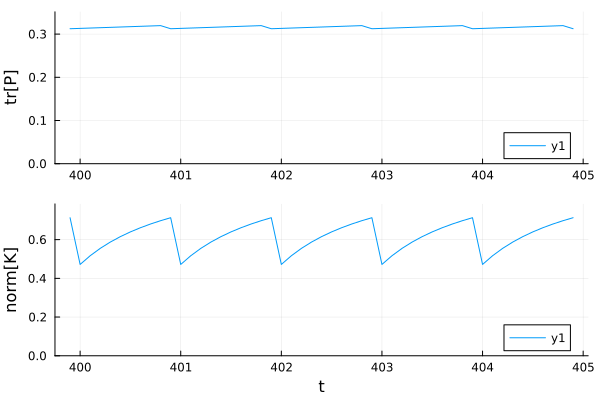

In [185]:
k1 = 4000
k2 = 4050
plot_gain(t[k1:k2], P[:,:,k1:k2], K[:,:,k1:k2])

In [170]:
# Generadores de datos 

function mru_IMU()
    return [0,0,0]
end
function mru_GPS(v, t, θ)
    return [v*t*cos(θ),v*t*sin(θ),θ]
end

mru_GPS (generic function with 1 method)

In [171]:
t_gps = t[1:10:end]

u_true = hcat([estatico_IMU() for ti in t]...)
z_true = hcat([mru_GPS(100/T, ti, pi/4) for ti in t]...)

u = u_true + u_noise
z = z_true + z_noise

x, P, K = kalman(t, 10, u, z)

([-1.455122915634084 -1.4551196746210693 … 71.04583210487 71.06043381484648; 0.0 6.482026029166666e-5 … 0.14600400068060956 0.14603019884896198; … ; 0.0 -0.00017170739514248183 … 0.1443657894650829 0.14465070737716967; 0.7855415121489706 0.785673858194218 … 0.7847011254566213 0.7843493454921657], [6.25 0.0 … 0.0 0.0; 0.0 6.25 … 0.0 0.0; … ; 0.0 0.0 … 6.25 0.0; 0.0 0.0 … 0.0 6.283185307179586;;; 6.31250000016 0.6250000032 … 2.020363492347095e-25 0.0; 0.6250000032 6.250000064 … 1.0576043079681538e-24 0.0; … ; -1.2500722377230287e-25 -2.2983727115458583e-25 … 6.250000064 0.0; 0.0 0.0 … 0.0 6.283185334595154;;; 6.5000000016 1.2500000128000002 … 1.0351342895623755e-25 0.0; 1.2500000128000002 6.250000128 … 3.6294765830931514e-24 0.0; … ; -3.2007887038344932e-25 9.950320908232273e-25 … 6.250000128 0.0; 0.0 0.0 … 0.0 6.283185362010721;;; … ;;; 0.15972719705013783 0.002020370544845382 … 1.2349267219469864e-22 0.0; 0.002020370544845382 5.0854141278523966e-5 … -6.461366311617965e-23 0.0; … ; 1.10

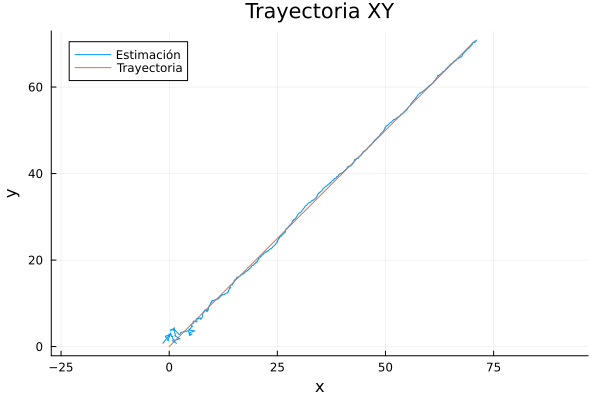

In [172]:
trayectoria_xy(x, z_true)

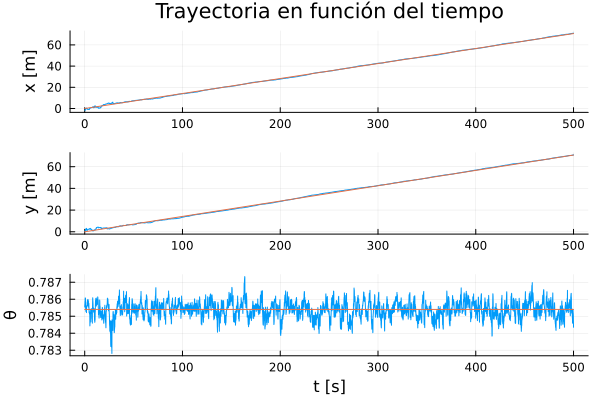

In [173]:
trayectoria_t(t, x, z_true)

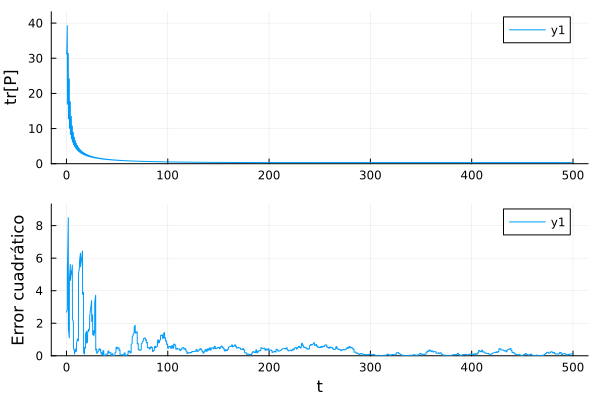

In [174]:

plot_error(t, x, z_true, P)

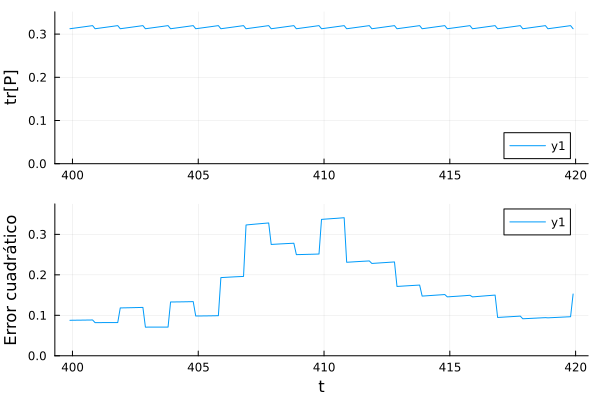

In [175]:
k1 = 4000
k2 = 4200
plot_error(t[k1:k2], x[:,k1:k2], z_true[:,k1:k2], P[:,:,k1:k2])

In [176]:
# Generadores de datos 

function circular_IMU(r, w, t)
    return [0,w^2*r,w] 
end

function circular_GPS(r, w, t)
    return [r*cos(w*t),r*sin(w*t),w*t+π/2] 
end

u_true = hcat([circular_IMU(20, 2*pi/T, ti) for ti in t]...)
z_true = hcat([circular_GPS(20, 2*pi/T, ti) for ti in t]...)

u = u_true + u_noise
z = z_true + z_noise

3×5001 Matrix{Float64}:
 18.5449   23.6599    17.9874    17.2268   …  20.562    20.6889   12.9903
  0.75353  -0.921717   0.657405  -4.96342      3.65828   2.87319   4.08529
  1.57094   1.57181    1.57291    1.57442      7.85208   7.85188   7.8543

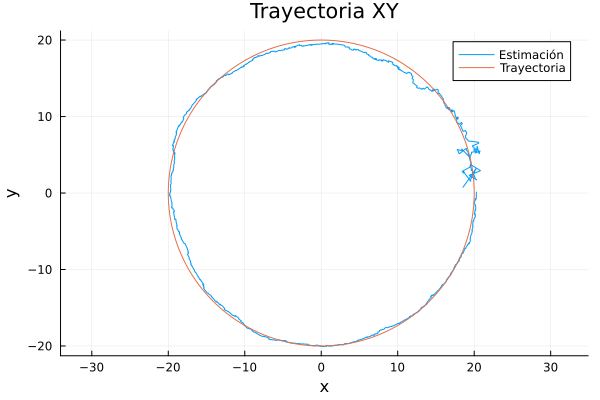

In [177]:
x, P, K = kalman(t, 10, u, z)

trayectoria_xy(x, z_true)

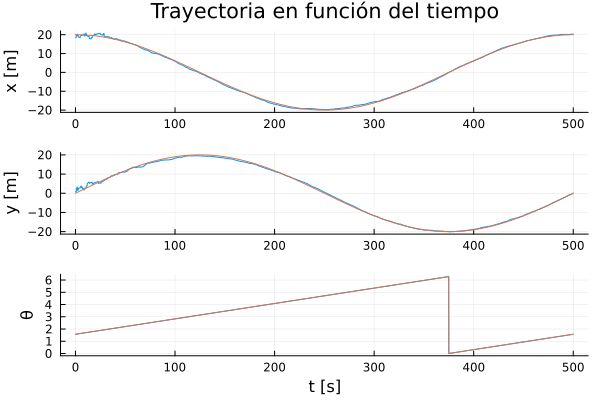

In [178]:
trayectoria_t(t, x, z_true)

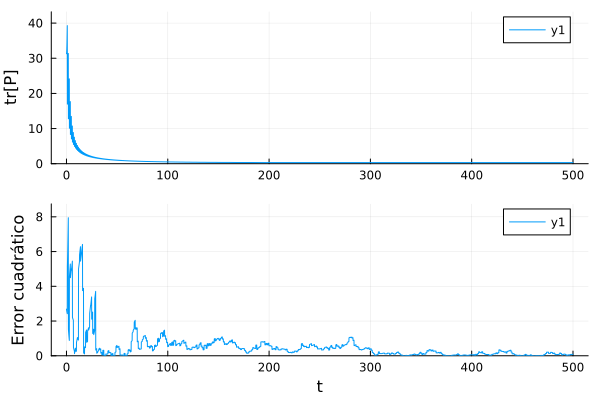

In [179]:

plot_error(t, x, z_true, P)

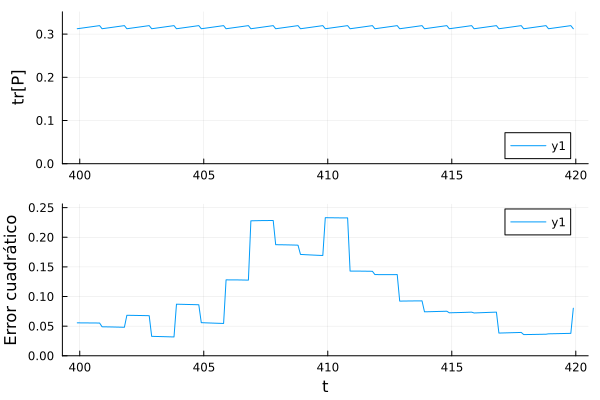

In [180]:
k1 = 4000
k2 = 4200
plot_error(t[k1:k2], x[:,k1:k2], z_true[:,k1:k2], P[:,:,k1:k2])